In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [3]:
route_gdf = gpd.read_file(f'{EXPORTS_DIR}/b25_220.shp').iloc[1:]

In [4]:
bk = ox.io.load_graphml('bk.graphml')
#bk = ox.io.load_graphml('b25.graphml')

In [5]:
#ox.io.save_graphml(bk, 'bk.graphml')

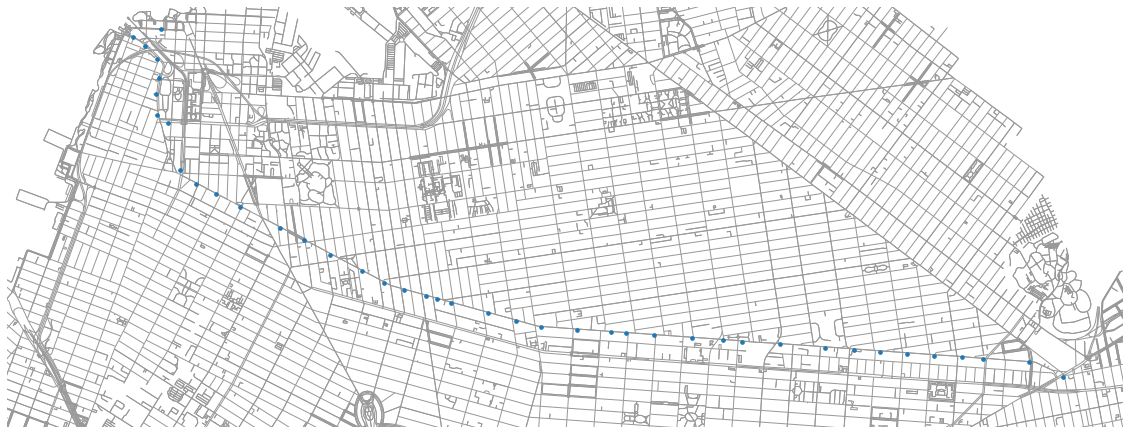

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
ox.plot_graph(bk, ax=ax, bgcolor=None, node_size=0, bbox=(40.70501, 40.67289, -73.89407, -74.00660), show=False, close=False)
route_gdf.plot(ax=ax, zorder=20, markersize=13)
plt.show()

In [7]:
ne = ox.nearest_edges(bk, route_gdf['stop_lon'], route_gdf['stop_lat'])

In [8]:
import itertools
nn = [[e[0], e[1]] for e in ne]
nn

[[7648015506, 8262935330],
 [3174844139, 3174844149],
 [3174844145, 598054754],
 [7014570048, 42519202],
 [219785432, 6224369594],
 [2842884211, 2842884214],
 [598043774, 42517603],
 [598043776, 42530376],
 [4487604244, 278634702],
 [42464827, 42464824],
 [588036470, 42464832],
 [42464844, 2696777590],
 [42464855, 42464854],
 [5780018158, 5780018153],
 [42464866, 42464871],
 [42464923, 42464925],
 [42464930, 42464932],
 [42464934, 42464936],
 [42464938, 42464941],
 [42464945, 42464941],
 [42464948, 5533091530],
 [42464955, 42464958],
 [42464960, 42464964],
 [42464967, 42464972],
 [42464975, 42464977],
 [42464982, 42464985],
 [42464982, 42464985],
 [42464988, 4224536022],
 [42464999, 42465002],
 [42465008, 42465011],
 [42465016, 1642909737],
 [42465024, 6545280304],
 [42465033, 8904004315],
 [5488505763, 5488505768],
 [42465043, 42465047],
 [42465054, 42465062],
 [42465062, 42465069],
 [42465072, 42465075],
 [1260335132, 42465075],
 [42465084, 42468791],
 [597773095, 597773107]]

In [9]:
def dedup_consecutive(a):
    b = []
    last = None
    for i in range(0, len(a)):
        c = a[i]
        if c != last:
            last = c
            b.append(c)
    return b

route_nodes = []
for i in range(0, len(nn) - 1):
    edge0 = nn[i]
    edge1 = nn[i + 1]
    sp = ox.shortest_path(bk, edge0[1], edge1[0])
    if sp is None:
        raise Exception('oof')
    nd = dedup_consecutive(edge0 + sp + [edge1[0]])
    route_nodes += nd

route_nodes = dedup_consecutive(route_nodes)


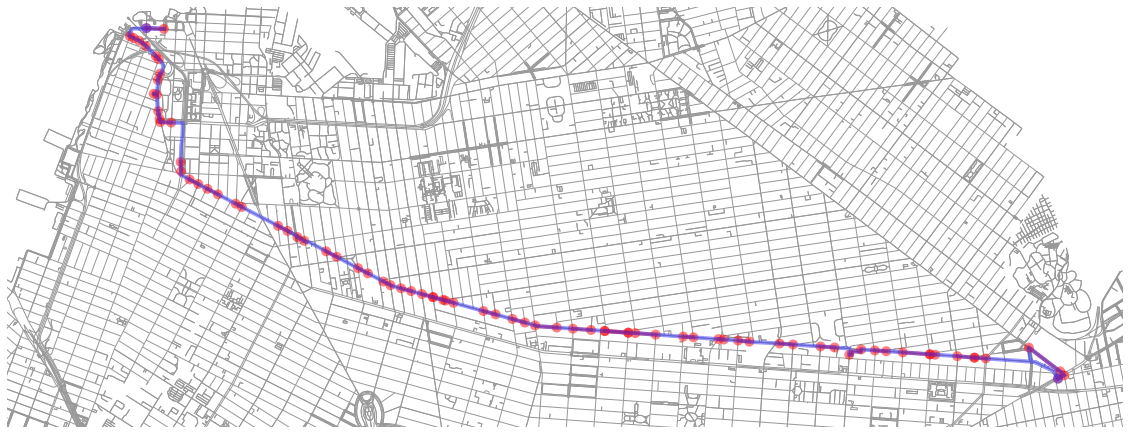

In [10]:
fig, ax = plt.subplots(figsize=(20, 20))
ox.plot_graph(bk, ax=ax, bgcolor=None, node_size=0, bbox=(40.70501, 40.67289, -73.89407, -74.00660), show=False, close=False)
ox.plot_graph_routes(bk, nn, ax=ax, show=False, close=False)
ox.plot_graph_route(bk, route_nodes, ax=ax, show=False, close=False, route_color='#3333ff')
plt.show()

In [11]:
import networkx as nx

In [12]:
graph = nx.MultiDiGraph()

In [13]:
def create_route_subgraph(node_ids):
    graph = nx.MultiDiGraph()
    for node_id in node_ids:
        node = bk.nodes[node_id]
        graph.add_node(node_id, **node)
    for i in range(0, len(node_ids) - 1):
        graph.add_edge(node_ids[i], node_ids[i + 1])
        if node_ids[i] == 42465016:
            print(f'node from {node_ids[i]}({i}) to {node_ids[i + 1]}({i + 1})')
    graph.graph['crs'] = CRS_PLOT
    return graph
route_graph = create_route_subgraph(route_nodes)
#ox.io.save_graphml(route_graph, 'b25.graphml')
#route_graph = ox.io.load_graphml('b25.graphml')

node from 42465016(125) to 1642909737(126)


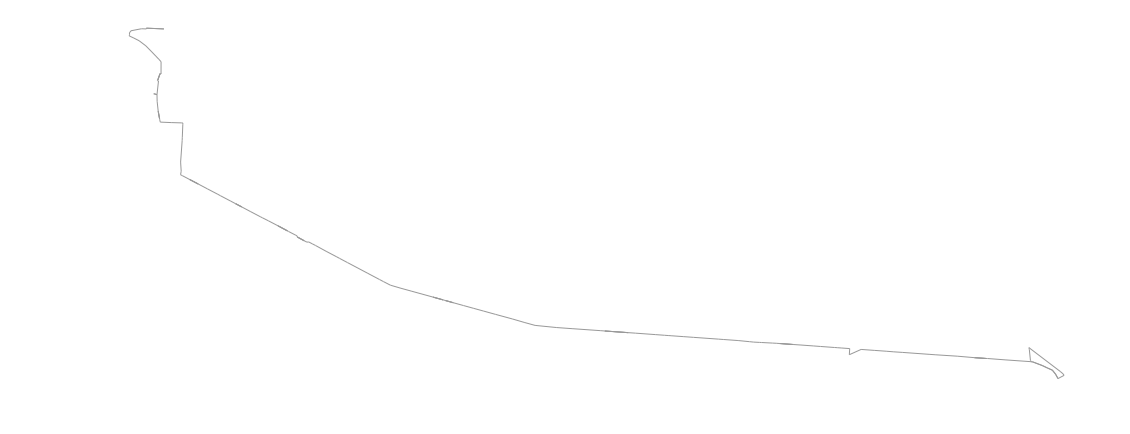

In [14]:
fig, ax = plt.subplots(figsize=(20, 20))
ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=0, bbox=(40.70501, 40.67289, -73.89407, -74.00660), show=False, close=False)
plt.show()

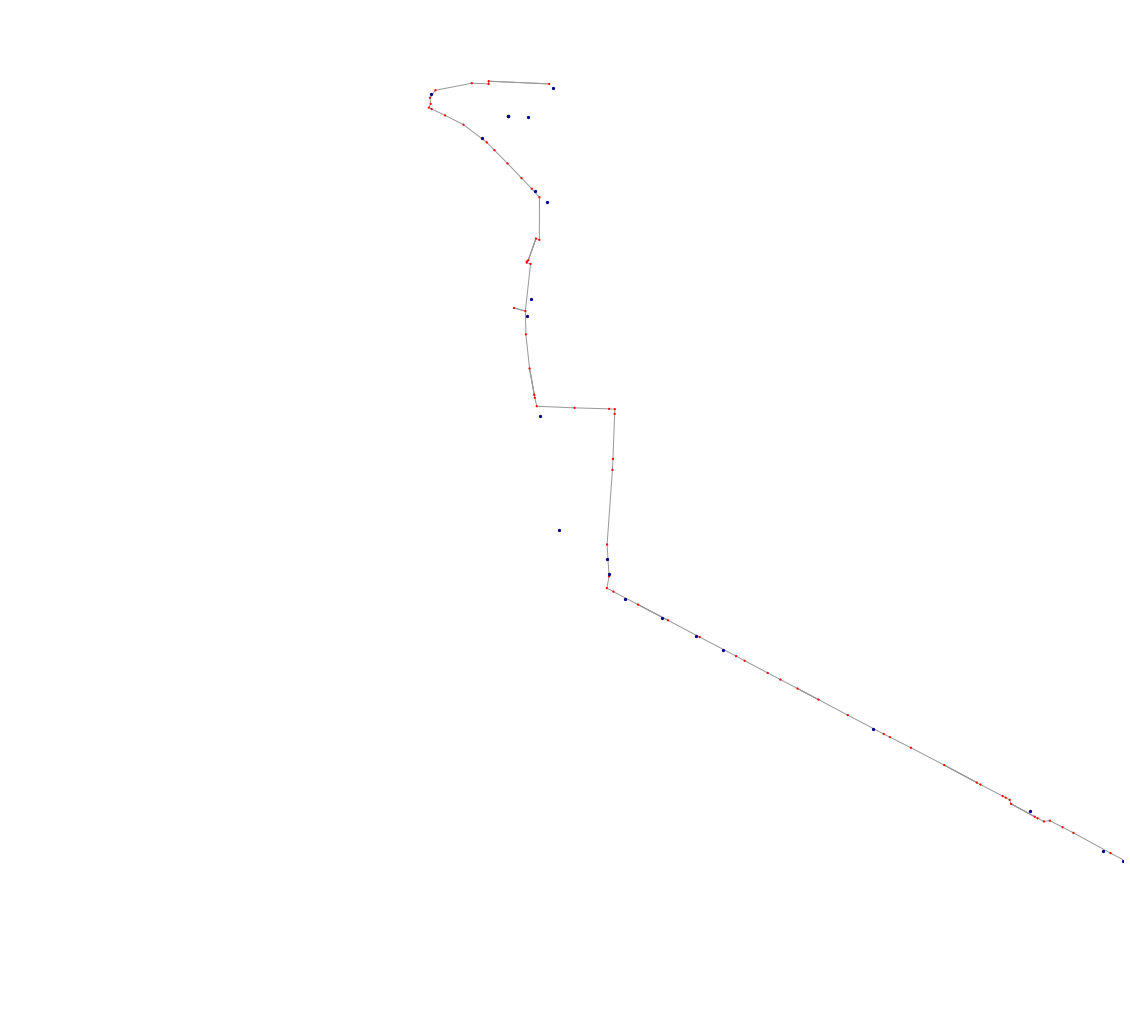

In [15]:
trajectory_df = pd.read_csv(f'{EXPORTS_DIR}/b25_7131.csv')
trajectory_gdf = gpd.GeoDataFrame(trajectory_df, geometry=gpd.points_from_xy(trajectory_df['longitude'], trajectory_df['latitude']), crs=CRS_PLOT)
trajectory_gdf.head()

fig, ax = plt.subplots(figsize=(20, 20))
ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=5, node_color='#ff0000', bbox=(40.70501, 40.68289, -73.97407, -74.00660), show=False, close=False)
trajectory_gdf.plot(ax=ax, color='darkblue', markersize=5, zorder=2)
plt.show()

plt.show()

In [16]:
ne = ox.nearest_edges(route_graph, route_gdf['stop_lon'], route_gdf['stop_lat'])

In [17]:
len(ne)

41

In [18]:
len(route_gdf)

41

In [19]:
len(route_nodes)

184

In [20]:
node_id_to_row_index_dict = {}
for row_index in range(0, len(ne)):
    edge = ne[row_index]
    node0 = edge[0]
    node1 = edge[1]
    node_id_to_row_index_dict[node0] = row_index
    node_id_to_row_index_dict[node1] = row_index

row_index = 1
for node_index in range(0, len(route_nodes)):
    node_id = route_nodes[node_index]
    
    row0 = route_gdf.iloc[row_index]
    row1 = route_gdf.iloc[row_index + 1]
    x0, y0 = row0['stop_lon'], row0['stop_lat']
    x1, y1 = row1['stop_lon'], row1['stop_lat']
    x = route_graph.nodes[node_id]['x']
    y = route_graph.nodes[node_id]['y']
    
    d0 = ox.distance.euclidean_dist_vec(y, x, y0, x0)
    d1 = ox.distance.euclidean_dist_vec(y, x, y1, x1)
    if d1 < d0:
        node_id_to_row_index_dict[node_id] = row_index + 1
        if row_index + 1 < len(route_gdf) - 1:
            row_index += 1
    else:
        node_id_to_row_index_dict[node_id] = row_index
print(node_id_to_row_index_dict)

{7648015506: 2, 8262935330: 2, 3174844139: 2, 3174844149: 2, 3174844145: 2, 598054754: 2, 7014570048: 3, 42519202: 3, 6224369594: 4, 219785432: 4, 2842884211: 5, 2842884214: 5, 42517603: 6, 598043774: 6, 598043776: 6, 42530376: 7, 4487604244: 8, 278634702: 8, 42464827: 9, 42464824: 9, 588036470: 10, 42464832: 10, 42464844: 11, 2696777590: 11, 42464854: 12, 42464855: 12, 5780018158: 13, 5780018153: 13, 42464866: 14, 42464871: 14, 42464923: 15, 42464925: 15, 42464930: 16, 42464932: 16, 42464934: 17, 42464936: 17, 42464938: 18, 42464941: 19, 42464945: 19, 5533091530: 20, 42464948: 20, 42464955: 21, 42464958: 21, 42464960: 22, 42464964: 22, 42464967: 23, 42464972: 23, 42464975: 24, 42464977: 24, 42464982: 26, 42464985: 26, 42464988: 26, 4224536022: 27, 42464999: 28, 42465002: 28, 42465008: 29, 42465011: 29, 42465016: 30, 1642909737: 30, 6545280304: 31, 42465024: 31, 42465033: 32, 8904004315: 32, 5488505763: 33, 5488505768: 33, 42465043: 34, 42465047: 34, 42465054: 35, 42465062: 36, 4246506

In [21]:
node_id_to_time_ratio_dict = {}
node_id_to_time_dict = {}
t = {}

route_gdf['departure_'] = pd.to_datetime(route_gdf['departure_'])
route_gdf['arrival_ti'] = pd.to_datetime(route_gdf['arrival_ti'])

for node_index in range(0, len(route_nodes)):
    node_id = route_nodes[node_index]
    row_index = node_id_to_row_index_dict[node_id]
    
    row0 = route_gdf.iloc[row_index - 1]
    row1 = route_gdf.iloc[row_index]
    x0, y0 = row0['stop_lon'], row0['stop_lat']
    x1, y1 = row1['stop_lon'], row1['stop_lat']
    t0 = row0['departure_']
    t1 = row1['arrival_ti']
    x = route_graph.nodes[node_id]['x']
    y = route_graph.nodes[node_id]['y']
    
    # Use route length instead of euclidean dist>
    
    # Route distance from node to stop1k
    d = ox.distance.euclidean_dist_vec(y, x, y1, x1)
    
    # Route distance from stop0 to stop1
    dr = ox.distance.euclidean_dist_vec(y0, x0, y1, x1)
    
    node_id_to_time_dict[node_id] = t1 - (d / dr) * (t1 - t0)

df = pd.DataFrame(node_id_to_time_dict.items(), columns=['node', 'datetime'])
display(df)

,node,datetime
0,7648015506,2021-07-28 12:50:05.302632184
1,8262935330,2021-07-28 12:49:35.863749008
2,42469329,2021-07-28 12:50:07.088621580
3,214362644,2021-07-28 12:50:05.927052700
4,999184452,2021-07-28 12:49:52.360190440
...,...,...
146,42465084,2021-07-28 13:56:38.443733335
147,42468791,2021-07-28 13:53:48.937217797
148,4970873186,2021-07-28 13:53:51.209408365
149,5708663658,2021-07-28 13:53:53.749122464


In [22]:
def snap_to_edge(point, edge):
    p1 = edge[0]
    p2 = edge[1]
    x1 = float(p1[0])
    y1 = float(p1[1])
    x2 = float(p2[0])
    y2 = float(p2[1])
    x3 = point[0]
    y3 = point[1]
    
    m1 = (y2 - y1) / (x2 - x1)
    m3 = -1.0 / m1
    x = (m1 * x1 - m3 * x3 - y1 + y3) / (m1 - m3)
    y = m1 * (x - x1) + y1
    return [x, y]

In [23]:
route_snapped_points = []
for i in range(0, len(ne)):
    stop_row = route_gdf.iloc[i]
    x, y = stop_row['stop_lon'], stop_row['stop_lat']
    
    edge = ne[i]
    node0 = route_graph.nodes[edge[0]]
    node1 = route_graph.nodes[edge[1]]
    snapped_point = snap_to_edge([x, y], [[node0['x'], node0['y']], [node1['x'], node1['y']]])
    route_snapped_points.append(snapped_point)
    

In [25]:
#fig, ax = plt.subplots(figsize=(40, 40))
#ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=10, node_color='black', bbox=(40.70501, 40.67289, -73.89407, -74.00660), show=False, close=False)
##ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=5, node_color='#000', bbox=(40.68501, 40.67289, -73.92407, -73.93660), show=False, close=False)
##route_gdf.plot(ax=ax, color='darkblue', markersize=5, zorder=2)
#
##stop = stops[30]
##X = [p[0] for p in route_snapped_points[32:33]]
##Y = [p[1] for p in route_snapped_points[32:33]]
#
#X = [route_graph.nodes[n]['x'] for n in route_nodes]
#Y = [route_graph.nodes[n]['y'] for n in route_nodes]
##ax.scatter(X, Y, color='darkred',)
#
#for i in range(0, len(X)):
#    x = X[i]
#    y = Y[i]
#    ax.annotate(i, (x, y))
#
##plt.show()
#
#
#
##ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=5, node_color='#000', bbox=(40.68501, 40.67289, -73.92407, -73.93660), show=False, close=False)
###route_gdf.plot(ax=ax, color='darkblue', markersize=5, zorder=2)
##
#stop = stops[30]
##X = [stop.x]
##Y = [stop.y]
##
#pnx = stop.prev_node['x']
#pny = stop.prev_node['y']
##
##nnx = stop.next_node['x']
##nny = stop.next_node['y']
##
#ax.scatter([stop.x], [stop.y], color='darkred',)
#ax.scatter([pnx], [pny], color='pink',)
#ax.scatter([nnx], [nny], color='purple',)
#print(stop.prev_node_index)
#print(stop.next_node_index)
#print(route_graph.has_edge(stop.prev_node_id, stop.next_node_id))
#print(route_graph.has_edge(stop.next_node_id, stop.prev_node_id))
##
#plt.show()

In [26]:
#print(route_graph.nodes[5062944258])
#x = route_gdf.iloc[0]['stop_lon']
#y = route_gdf.iloc[0]['stop_lat']
#print(x, y)
#print(ox.nearest_edges(route_graph, x, y))
#print(route_graph.nodes[7648015506])
#print(route_graph.nodes[8262935330])
#ne = ox.nearest_edges(route_graph, route_gdf['stop_lon'], route_gdf['stop_lat'])
#print(ne)

In [57]:
class Stop:
    def __init__(self, i=0, x=0, y=0, t=0):
        self.i = i
        self.x = x
        self.y = y
        self.t = t
        self.st = 0
        
        self.edge = ox.nearest_edges(route_graph, [self.x], [self.y])[0]
        
        self.prev_node_id = self.edge[0]
        self.next_node_id = self.edge[1]
        self.prev_node_index = route_nodes.index(self.prev_node_id)
        try:
            self.next_node_index = route_nodes.index(self.next_node_id, self.prev_node_index)
        except ValueError:
            self.next_node_index = route_nodes.index(self.next_node_id)
        
        self.prev_node = route_graph.nodes[self.prev_node_id]
        self.next_node = route_graph.nodes[self.next_node_id]
        
        route_point = snap_to_edge([x, y], [[self.prev_node['x'], self.prev_node['y']], [self.next_node['x'], self.next_node['y']]])
        self.rx = route_point[0]
        self.ry = route_point[1]
        
        self.prev_node_dist = ox.distance.euclidean_dist_vec(self.ry, self.rx, self.prev_node['y'], self.prev_node['x'])
        self.next_node_dist = ox.distance.euclidean_dist_vec(self.ry, self.rx, self.next_node['y'], self.next_node['x'])
        
    def get_nearest_edge(self):
        edge = ox.nearest_edges(route_graph, route_gdf['stop_lon'], route_gdf['stop_lat'])
        
stops = []
for i in range(0, len(route_gdf)):
    row = route_gdf.iloc[i]
    stop = Stop(i=0, x=row['stop_lon'], y=row['stop_lat'], t=row['departure_'])
    stops.append(stop)

df = pd.DataFrame({
    'i': [s.i for s in stops],
    'x': [s.x for s in stops],
    'y': [s.y for s in stops],
    't': [s.t for s in stops],
    'prev_node_id': [s.prev_node_id for s in stops],
    'next_node_id': [s.next_node_id for s in stops],
    'prev_node_index': [s.prev_node_index for s in stops],
    'next_node_index': [s.next_node_index for s in stops],
    'rx': [s.rx for s in stops],
    'ry': [s.ry for s in stops],
    'prev_node_dist': [s.prev_node_dist for s in stops],
    'next_node_dist': [s.next_node_dist for s in stops],
})
display(df)
df2 = pd.DataFrame([i, route_nodes[i]] for i in range(0, len(route_nodes)))

,i,x,y,t,prev_node_id,next_node_id,prev_node_index,next_node_index,rx,ry,prev_node_dist,next_node_dist
0,0,-73.991102,40.703318,2021-07-28 12:48:13,7648015506,8262935330,0,1,-73.991102,40.703320,0.001465,0.000303
1,0,-73.993952,40.702666,2021-07-28 12:50:05,3174844139,3174844149,9,10,-73.993955,40.702657,0.000290,0.000125
2,0,-73.992747,40.702029,2021-07-28 12:50:46,3174844145,598054754,11,12,-73.992721,40.702075,0.000669,0.000116
3,0,-73.991449,40.701021,2021-07-28 12:51:37,7014570048,42519202,15,16,-73.991409,40.701071,0.000255,0.000127
4,0,-73.991290,40.699591,2021-07-28 12:52:37,6224369594,219785432,19,20,-73.991321,40.699605,0.000316,0.000214
5,0,-73.991565,40.698348,2021-07-28 12:53:21,2842884211,2842884214,26,27,-73.991573,40.698306,0.000079,0.000257
6,0,-73.991464,40.696696,2021-07-28 12:54:20,42517603,598043774,30,31,-73.991306,40.696733,0.000295,0.000304
7,0,-73.990366,40.696104,2021-07-28 12:55:00,598043776,42530376,35,36,-73.990364,40.696160,0.000801,0.000301
8,0,-73.989131,40.692560,2021-07-28 12:59:58,4487604244,278634702,42,43,-73.989067,40.692565,0.000567,0.000143
9,0,-73.987534,40.691480,2021-07-28 13:01:54,42464827,42464824,47,48,-73.987516,40.691525,0.000191,0.000750


In [28]:
distances_to_next_node = []
for i in range(0, len(route_nodes) - 1):
    node = route_graph.nodes[route_nodes[i]]
    next_node = route_graph.nodes[route_nodes[i + 1]]
    
    dist = ox.distance.euclidean_dist_vec(node['y'], node['x'], next_node['y'], next_node['x'])
    distances_to_next_node.append(dist)

In [49]:
class RouteNode:
    def __init__(self, i=0, id=0, node=None):
        self.i = i
        self.id = id
        self.node = node
        self.next_node = None
        self.x = node['x']
        self.y = node['y']
        self.t = 0
        self.st = 0
        
    def set_next_node(self, next_node):
        self.next_node = next_node
        self.distance_to_next =ox.distance.euclidean_dist_vec(self.y, self.x, next_node.y, next_node.x)

route_node_list = []

for i in range(0, len(route_nodes)):
    id = route_nodes[i]
    route_node_list.append(RouteNode(i, id, route_graph.nodes[id]))
    
for i in range(0, len(route_nodes) - 1):
    route_node_list[i].set_next_node(route_node_list[i + 1])

In [50]:
for k in range(0, len(stops) - 1):
    stop = stops[k] 
    stop.next_node_index
    next_stop = stops[k + 1]
    next_stop.prev_node_index

    total_dist = stop.next_node_dist
    for i in range(stop.next_node_index, next_stop.prev_node_index + 1):
        total_dist += route_node_list[i].distance_to_next
    total_dist += next_stop.prev_node_dist
    t0 = stop.t
    t1 = next_stop.t

    for i in range(stop.next_node_index, next_stop.prev_node_index + 1):
        node_dist = 0
        for j in range(i, next_stop.prev_node_index + 1):
            node_dist += route_node_list[j].distance_to_next
        node_dist += next_stop.prev_node_dist

        ratio = (total_dist - node_dist) / total_dist
        route_node_list[i].t = (t1 - t0) * ratio + t0
       

In [59]:
for k in range(0, len(trajectory_points) - 1):
    trajectory_point = trajectory_points[k] 
    trajectory_point.next_node_index
    next_trajectory_point = trajectory_points[k + 1]
    next_trajectory_point.prev_node_index

    total_dist = trajectory_point.next_node_dist
    for i in range(trajectory_point.next_node_index, next_trajectory_point.prev_node_index + 1):
        total_dist += route_node_list[i].distance_to_next
    total_dist += next_trajectory_point.prev_node_dist
    t0 = trajectory_point.t
    t1 = next_trajectory_point.t

    for i in range(trajectory_point.next_node_index, next_trajectory_point.prev_node_index + 1):
        node_dist = 0
        for j in range(i, next_trajectory_point.prev_node_index + 1):
            node_dist += route_node_list[j].distance_to_next
        node_dist += next_trajectory_point.prev_node_dist

        ratio = (total_dist - node_dist) / total_dist
        route_node_list[i].st = (t1 - t0) * ratio + t0

In [71]:
for k in range(0, len(stops) - 1):
    stop = stops[k]
    stop_prev_node = route_node_list[stop.prev_node_index]
    stop_next_node = route_node_list[stop.next_node_index]
    if stop_prev_node.st != 0 and stop_next_node.st != 0:
        ratio = stop.prev_node_dist / (stop.prev_node_dist + stop.next_node_dist)
        t0 = stop_prev_node.st
        t1 = stop_next_node.st
        stop.st = (t1 - t0) * ratio + t0

In [58]:
pd.DataFrame({
    'i': [n.i for n in route_node_list],
    't': [n.t for n in route_node_list],
    'st': [n.st for n in route_node_list],
}).iloc[6:170]

,i,t,st
6,6,2021-07-28 12:49:41.795830955,2021-06-03 13:08:16.425432419
7,7,2021-07-28 12:49:44.901997151,2021-06-03 13:08:22.487097551
8,8,2021-07-28 12:49:47.074935900,2021-06-03 13:08:26.727574789
9,9,2021-07-28 12:49:49.026193395,2021-06-03 13:08:30.535442358
10,10,2021-07-28 12:50:07.377032412,2021-06-03 13:08:48.879327895
...,...,...,...
165,165,2021-07-28 13:53:11.303590731,2021-06-03 14:10:33.005487822
166,166,2021-07-28 13:53:14.008628481,2021-06-03 14:10:58.582364282
167,167,2021-07-28 13:53:15.313399147,2021-06-03 14:11:23.855202154
168,168,2021-07-28 13:53:21.494151545,0


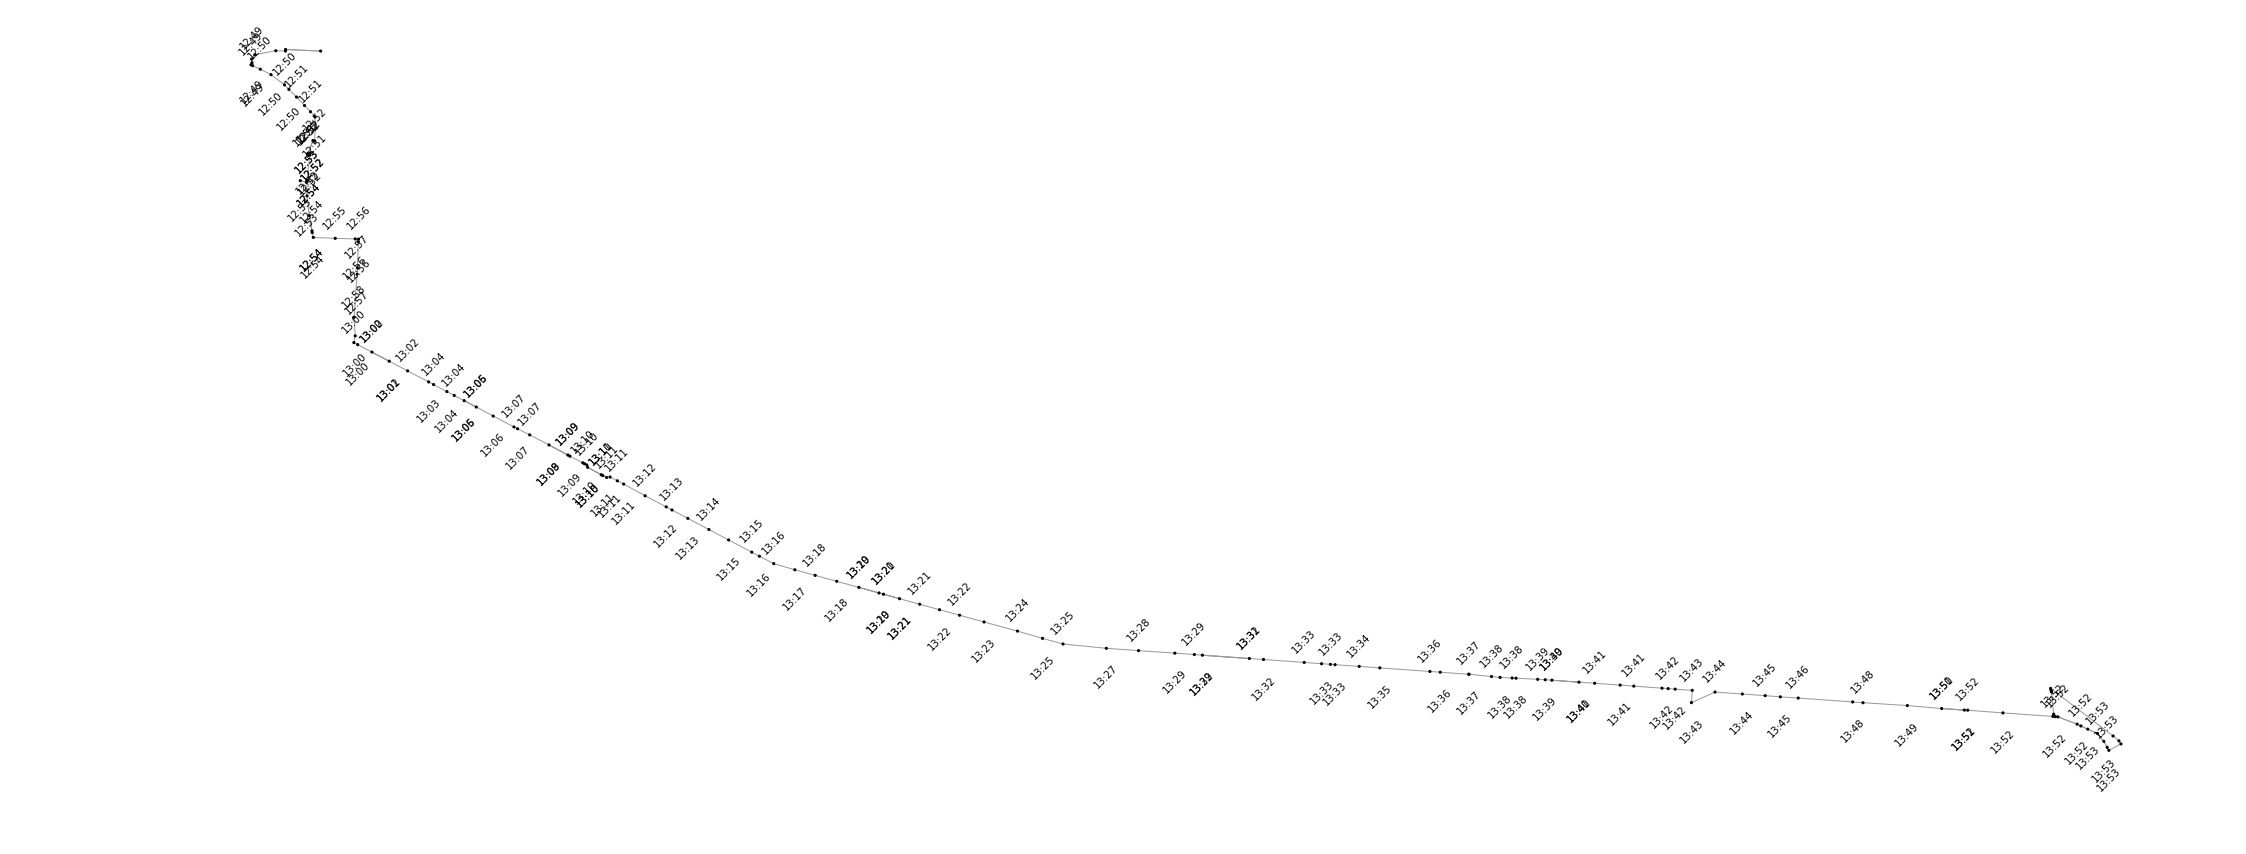

In [32]:
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=10, node_color='black', bbox=(40.70501, 40.67289, -73.89407, -74.00660), show=False, close=False)

X = [route_graph.nodes[n]['x'] for n in route_nodes]
Y = [route_graph.nodes[n]['y'] for n in route_nodes]

for i in range(6, 168):
    x = X[i]
    y = Y[i]
    k = 1 if i % 2 == 0 else -4
    if route_node_list[i].t != 0:
        ax.annotate(route_node_list[i].t.strftime('%H:%M'), (x, y),
                   xytext=(0, 10 * k), textcoords='offset pixels', rotation=45, ha='center')

plt.show()

In [33]:
class Trajectory(Stop):
    def __init__(self, i=0, x=0, y=0, t=0):
        super().__init__(i, x, y, t)
        
        next_node_t = route_node_list[self.next_node_index].t
        prev_node_t = route_node_list[self.prev_node_index].t
        
        if next_node_t == 0:
            self.t_expected = None
        elif prev_node_t == 0:
            self.t_expected = None
        else:
            next_node_t -= datetime.timedelta(days=51)
            prev_node_t -= datetime.timedelta(days=51)
            self.t_expected = (self.prev_node_dist / (self.prev_node_dist + self.next_node_dist)) * (next_node_t - prev_node_t) + prev_node_t

trajectory_df = pd.read_csv(f'{EXPORTS_DIR}/b25_4845.csv')
trajectory_gdf = gpd.GeoDataFrame(trajectory_df, geometry=gpd.points_from_xy(trajectory_df['longitude'], trajectory_df['latitude']), crs=CRS_PLOT)
trajectory_gdf['datetime'] = pd.to_datetime(trajectory_gdf['datetime'])
trajectory_gdf

trajectory_points = []
for i in range(0, len(trajectory_gdf)):
    row = trajectory_gdf.iloc[i]
    trajectory_points.append(Trajectory(i=0, x=row['longitude'], y=row['latitude'], t=row['datetime']))

In [34]:
tp = trajectory_points[2]
print((tp.t_expected - tp.t).total_seconds() / 60)


5742.052014666667


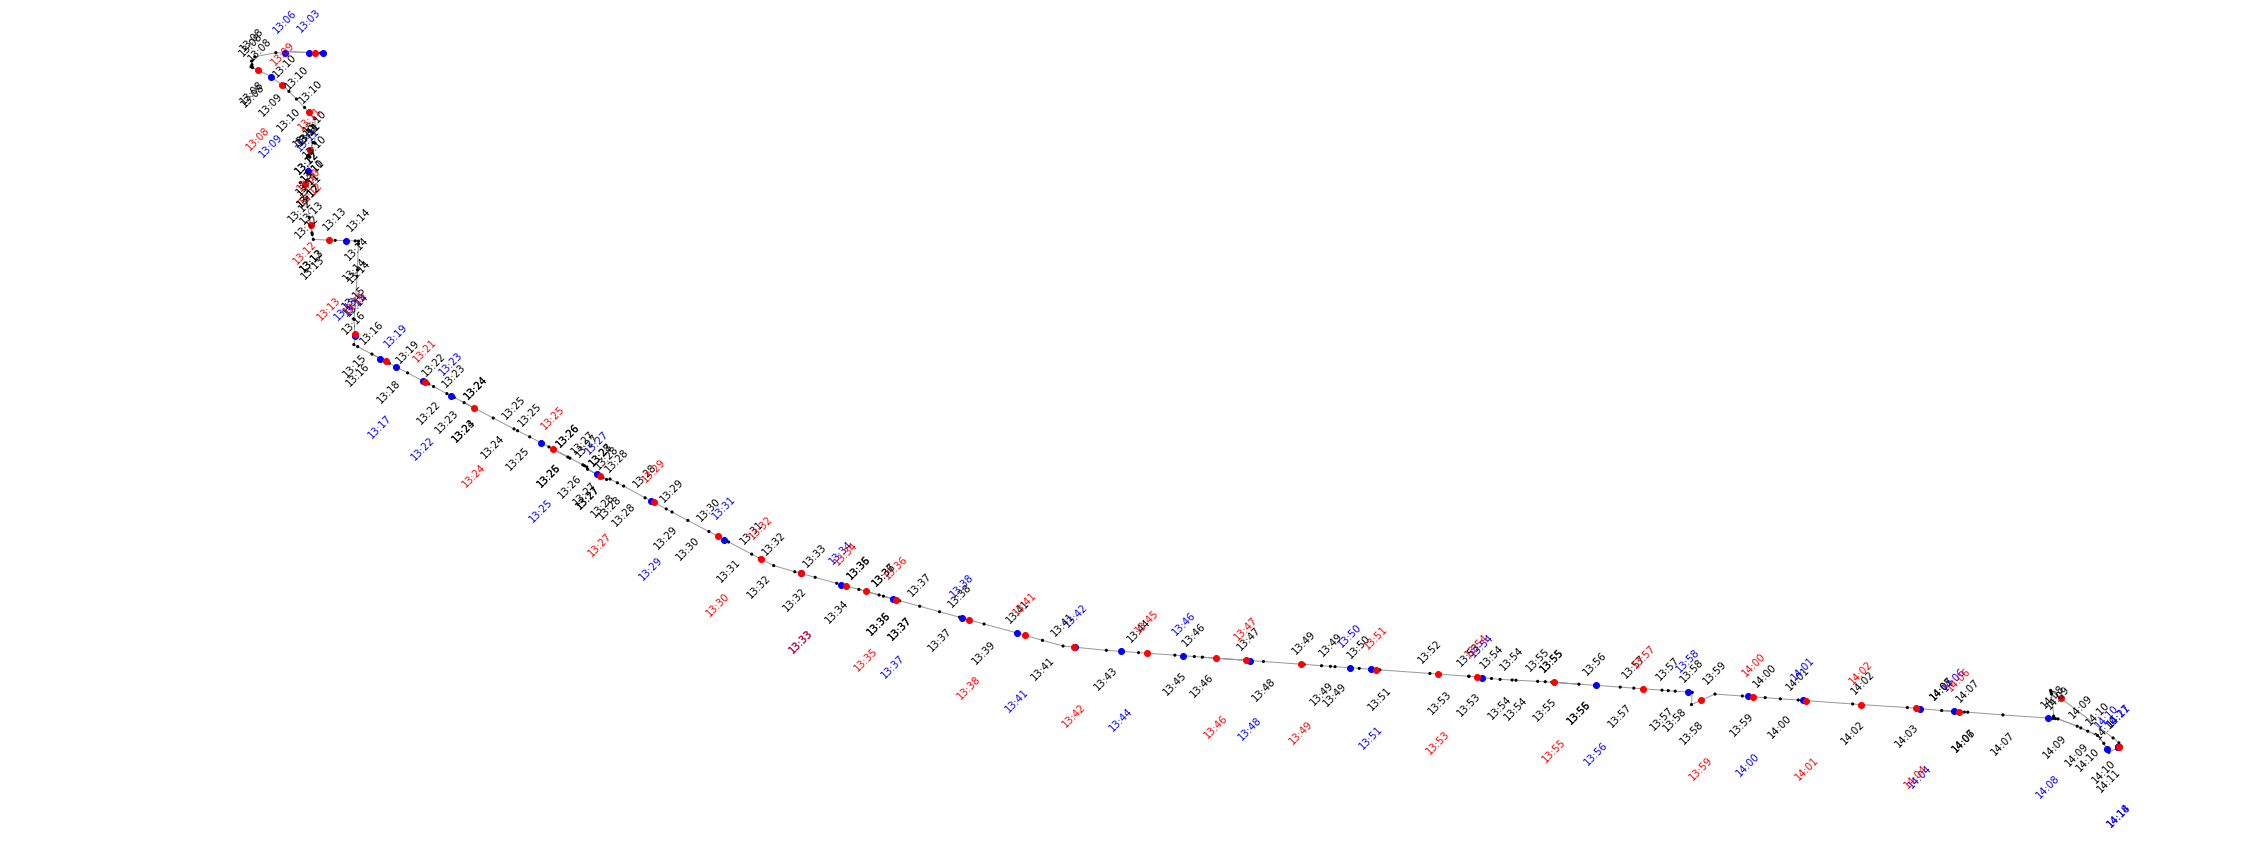

In [72]:
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=10, node_color='black', bbox=(40.70501, 40.67289, -73.89407, -74.00660), show=False, close=False)

X = [route_graph.nodes[n]['x'] for n in route_nodes]
Y = [route_graph.nodes[n]['y'] for n in route_nodes]

for i in range(6, 168):
    x = X[i]
    y = Y[i]
    k = 1 if i % 2 == 0 else -4
    if route_node_list[i].st != 0:
        ax.annotate(route_node_list[i].st.strftime('%H:%M'), (x, y),
                   xytext=(0, 10 * k), textcoords='offset pixels', rotation=45, ha='center', color='black')
    
X = [t.rx for t in trajectory_points]
Y = [t.ry for t in trajectory_points]
ax.scatter(X, Y, color='blue')

for i in range(0, len(trajectory_points)):
    x = X[i]
    y = Y[i]
    k = 1 if i % 2 == 0 else -4
    tp = trajectory_points[i]
    if tp.t_expected != None and tp.t != 0:
        ax.annotate(tp.t.strftime('%H:%M'), (x, y),
                   xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='blue')


X = [t.rx for t in stops]
Y = [t.ry for t in stops]
ax.scatter(X, Y, color='red')

for i in range(0, len(stops)):
    x = X[i]
    y = Y[i]
    k = 1 if i % 2 == 0 else -4
    stop = stops[i]
    if stop.st != None and stop.st != 0:
        ax.annotate(stop.st.strftime('%H:%M'), (x, y),
                   xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='red')

plt.show()

In [97]:
columns = list(route_gdf['stop_id'])
route_actual_times = pd.DataFrame({column: [stop.st.strftime('%H:%M:%S') if stop.st != 0 else None] for (column, stop) in zip(columns, stops)}, columns=columns)

In [86]:
stop_times_df = pd.read_csv(f'{EXPORTS_DIR}/b25_weekday_stop_times.csv')
stop_times_df

,trip_id,308626,308025,302355,306437,302356,302357,302359,302358,303011,...,307253,307254,307255,307256,307257,307259,307260,307631,307263,901211
0,EN_B1-Weekday-SDon-005800_B25_201,00:58:00,00:58:55,01:00:19,01:00:49,01:01:28,01:02:13,01:02:46,01:03:30,01:04:00,...,01:27:53,01:29:11,01:30:00,01:31:13,01:32:26,01:33:42,01:34:58,01:35:57,01:38:04,01:40:00
1,EN_B1-Weekday-SDon-014400_B25_201,02:24:00,02:24:46,02:25:56,02:26:21,02:26:53,02:27:31,02:27:58,02:28:35,02:29:00,...,02:49:53,02:51:11,02:52:00,02:52:59,02:53:57,02:54:57,02:55:58,02:56:45,02:58:27,03:00:00
2,EN_B1-Weekday-SDon-021800_B25_201,03:38:00,03:38:46,03:39:56,03:40:21,03:40:53,03:41:31,03:41:58,03:42:35,03:43:00,...,04:03:53,04:05:11,04:06:00,04:06:59,04:07:57,04:08:57,04:09:58,04:10:45,04:12:27,04:14:00
3,EN_B1-Weekday-SDon-029200_B25_201,04:52:00,04:52:46,04:53:56,04:54:21,04:54:53,04:55:31,04:55:58,04:56:35,04:57:00,...,05:17:53,05:19:11,05:20:00,05:20:59,05:21:57,05:22:57,05:23:58,05:24:45,05:26:27,05:28:00
4,EN_B1-Weekday-SDon-033200_Q56_453,05:32:00,05:33:04,05:34:42,05:35:17,05:36:02,05:36:55,05:37:34,05:38:25,05:39:00,...,06:03:37,06:05:05,06:06:00,06:07:13,06:08:26,06:09:42,06:10:58,06:11:57,06:14:04,06:16:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,EN_B1-Weekday-130900_B83_317,21:49:00,21:50:23,21:52:28,21:53:14,21:54:11,21:55:19,21:56:09,21:57:15,21:58:00,...,22:32:49,22:34:46,22:36:00,22:37:21,22:38:41,22:40:04,22:41:27,22:42:32,22:44:52,22:47:00
100,EN_B1-Weekday-133200_B25_238,22:12:00,22:13:23,22:15:28,22:16:14,22:17:11,22:18:19,22:19:09,22:20:15,22:21:00,...,22:55:49,22:57:46,22:59:00,23:00:21,23:01:41,23:03:04,23:04:27,23:05:32,23:07:52,23:10:00
101,EN_B1-Weekday-135700_B25_235,22:37:00,22:38:23,22:40:28,22:41:14,22:42:11,22:43:19,22:44:09,22:45:15,22:46:00,...,23:18:05,23:19:52,23:21:00,23:22:13,23:23:26,23:24:42,23:25:58,23:26:57,23:29:04,23:31:00
102,EN_B1-Weekday-138200_B83_319,23:02:00,23:03:23,23:05:28,23:06:14,23:07:11,23:08:19,23:09:09,23:10:15,23:11:00,...,23:40:21,23:41:59,23:43:00,23:44:13,23:45:26,23:46:42,23:47:58,23:48:57,23:51:04,23:53:00


In [105]:
start_col = route_actual_times.columns[1]
actual_time = pd.to_datetime(route_actual_times[start_col].iloc[0])

2021-07-28 13:08:43


In [130]:
from datetime import timedelta
stop_diffs_df = stop_times_df.copy()[['trip_id', str(start_col)]]
stop_diffs_df[str(start_col)] = pd.to_datetime(stop_diffs_df[str(start_col)])
stop_diffs_df['diff'] = stop_diffs_df[str(start_col)] - actual_time
threshold = 5
matching_df = stop_diffs_df[(stop_diffs_df['diff'] < timedelta(minutes=threshold)) & (stop_diffs_df['diff'] > timedelta(minutes=-threshold))]
matching_trips = list(matching_df['trip_id'])
matching_df


,trip_id,302355,diff
44,EN_B1-Weekday-SDon-078200_Q24_410,2021-07-28 13:05:05,-1 days +23:56:22
45,EN_B1-Weekday-079000_B25_223,2021-07-28 13:13:05,0 days 00:04:22


In [145]:
df_a = stop_times_df[stop_times_df['trip_id'].isin(matching_trips[0:1])]
df_b = route_actual_times

df_a.columns = [str(c) for c in df_a.columns]
df_b.columns = [str(c) for c in df_b.columns]

pd.concat([df_a, df_b])

,trip_id,308626,308025,302355,306437,302356,302357,302359,302358,303011,...,307253,307254,307255,307256,307257,307259,307260,307631,307263,901211
44,EN_B1-Weekday-SDon-078200_Q24_410,13:02:00,13:03:13,13:05:05,13:05:46,13:06:37,13:07:37,13:08:21,13:09:20,13:10:00,...,13:55:02,13:57:28,13:59:00,14:00:35,14:02:10,14:03:48,14:05:27,14:06:44,14:09:29,14:12:00
0,NaN,NaN,None,13:08:43,13:09:55,13:10:29,13:11:00,13:12:03,13:12:39,13:13:23,...,13:55:17,13:57:26,13:59:03,14:00:19,14:01:15,14:02:44,14:04:06,14:06:57,None,None


In [146]:
route_actual_times

,308025,302355,306437,302356,302357,302359,302358,303011,307460,302945,...,307253,307254,307255,307256,307257,307259,307260,307631,307263,901211
0,None,13:08:43,13:09:55,13:10:29,13:11:00,13:12:03,13:12:39,13:13:23,13:15:52,None,...,13:55:17,13:57:26,13:59:03,14:00:19,14:01:15,14:02:44,14:04:06,14:06:57,None,None
